In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/arthur/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imshow', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import utils as tutils
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
from torchvision import models

In [15]:
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = datasets.MNIST('mnist', train=True, download=True, transform=transform)
trainloader = tutils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)

mnist_test = datasets.MNIST('mnist', train=False, download=True, transform=transform)
testloader = tutils.data.DataLoader(mnist_test, batch_size=8, shuffle=True)

classes_mnist = tuple(i for i in range(10))

In [16]:
shape = mnist_train[0][0].shape

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, dims):
        super(AutoEncoder, self).__init__()

        self.encoder = self._build_seq(dims)
        self.decoder = self._build_seq(dims[::-1], decode=True)
 
        
    def _build_seq(self, dims, decode=False):
        layers = []
        for i in range(len(dims) - 1):
            layers.extend([
                nn.Linear(dims[i], dims[i + 1]),
                nn.ReLU(True) if not decode or i != len(dims) - 2 else nn.Sigmoid()
            ])
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [18]:
net = AutoEncoder([shape[0] * shape[1] * shape[2], 200, 100, 50, 30])
print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=50, out_features=30, bias=True)
    (7): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=100, out_features=200, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=200, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [19]:
criterion = F.binary_cross_entropy
optimizer = optim.Adam(net.parameters())

In [20]:
n_epochs = 10

for epoch in range(n_epochs):
    running_loss = 0.
    
    for images, _ in trainloader:
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
    print('Epoch: {}, Loss: {}'.format(epoch, running_loss))

Epoch: 0, Loss: 67.98085318505764
Epoch: 1, Loss: 50.3136422932148
Epoch: 2, Loss: 39.53160087764263
Epoch: 3, Loss: 35.731588661670685
Epoch: 4, Loss: 33.788797587156296
Epoch: 5, Loss: 32.45523265004158
Epoch: 6, Loss: 31.6085012704134
Epoch: 7, Loss: 31.0033962354064
Epoch: 8, Loss: 30.534914292395115
Epoch: 9, Loss: 30.12254137545824


In [21]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)

def display_batch(images, reshape=False):
    if reshape:
        images = images.view(images.shape[0], 1, 28, 28)
    imshow(vutils.make_grid(images))

In [22]:
images, labels = next(iter(testloader))

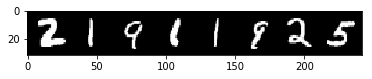

In [23]:
display_batch(images)

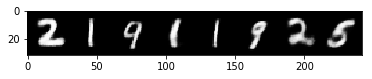

In [24]:
compressed_images = net(images.view(images.shape[0], -1))
display_batch(compressed_images.detach(), reshape=True)